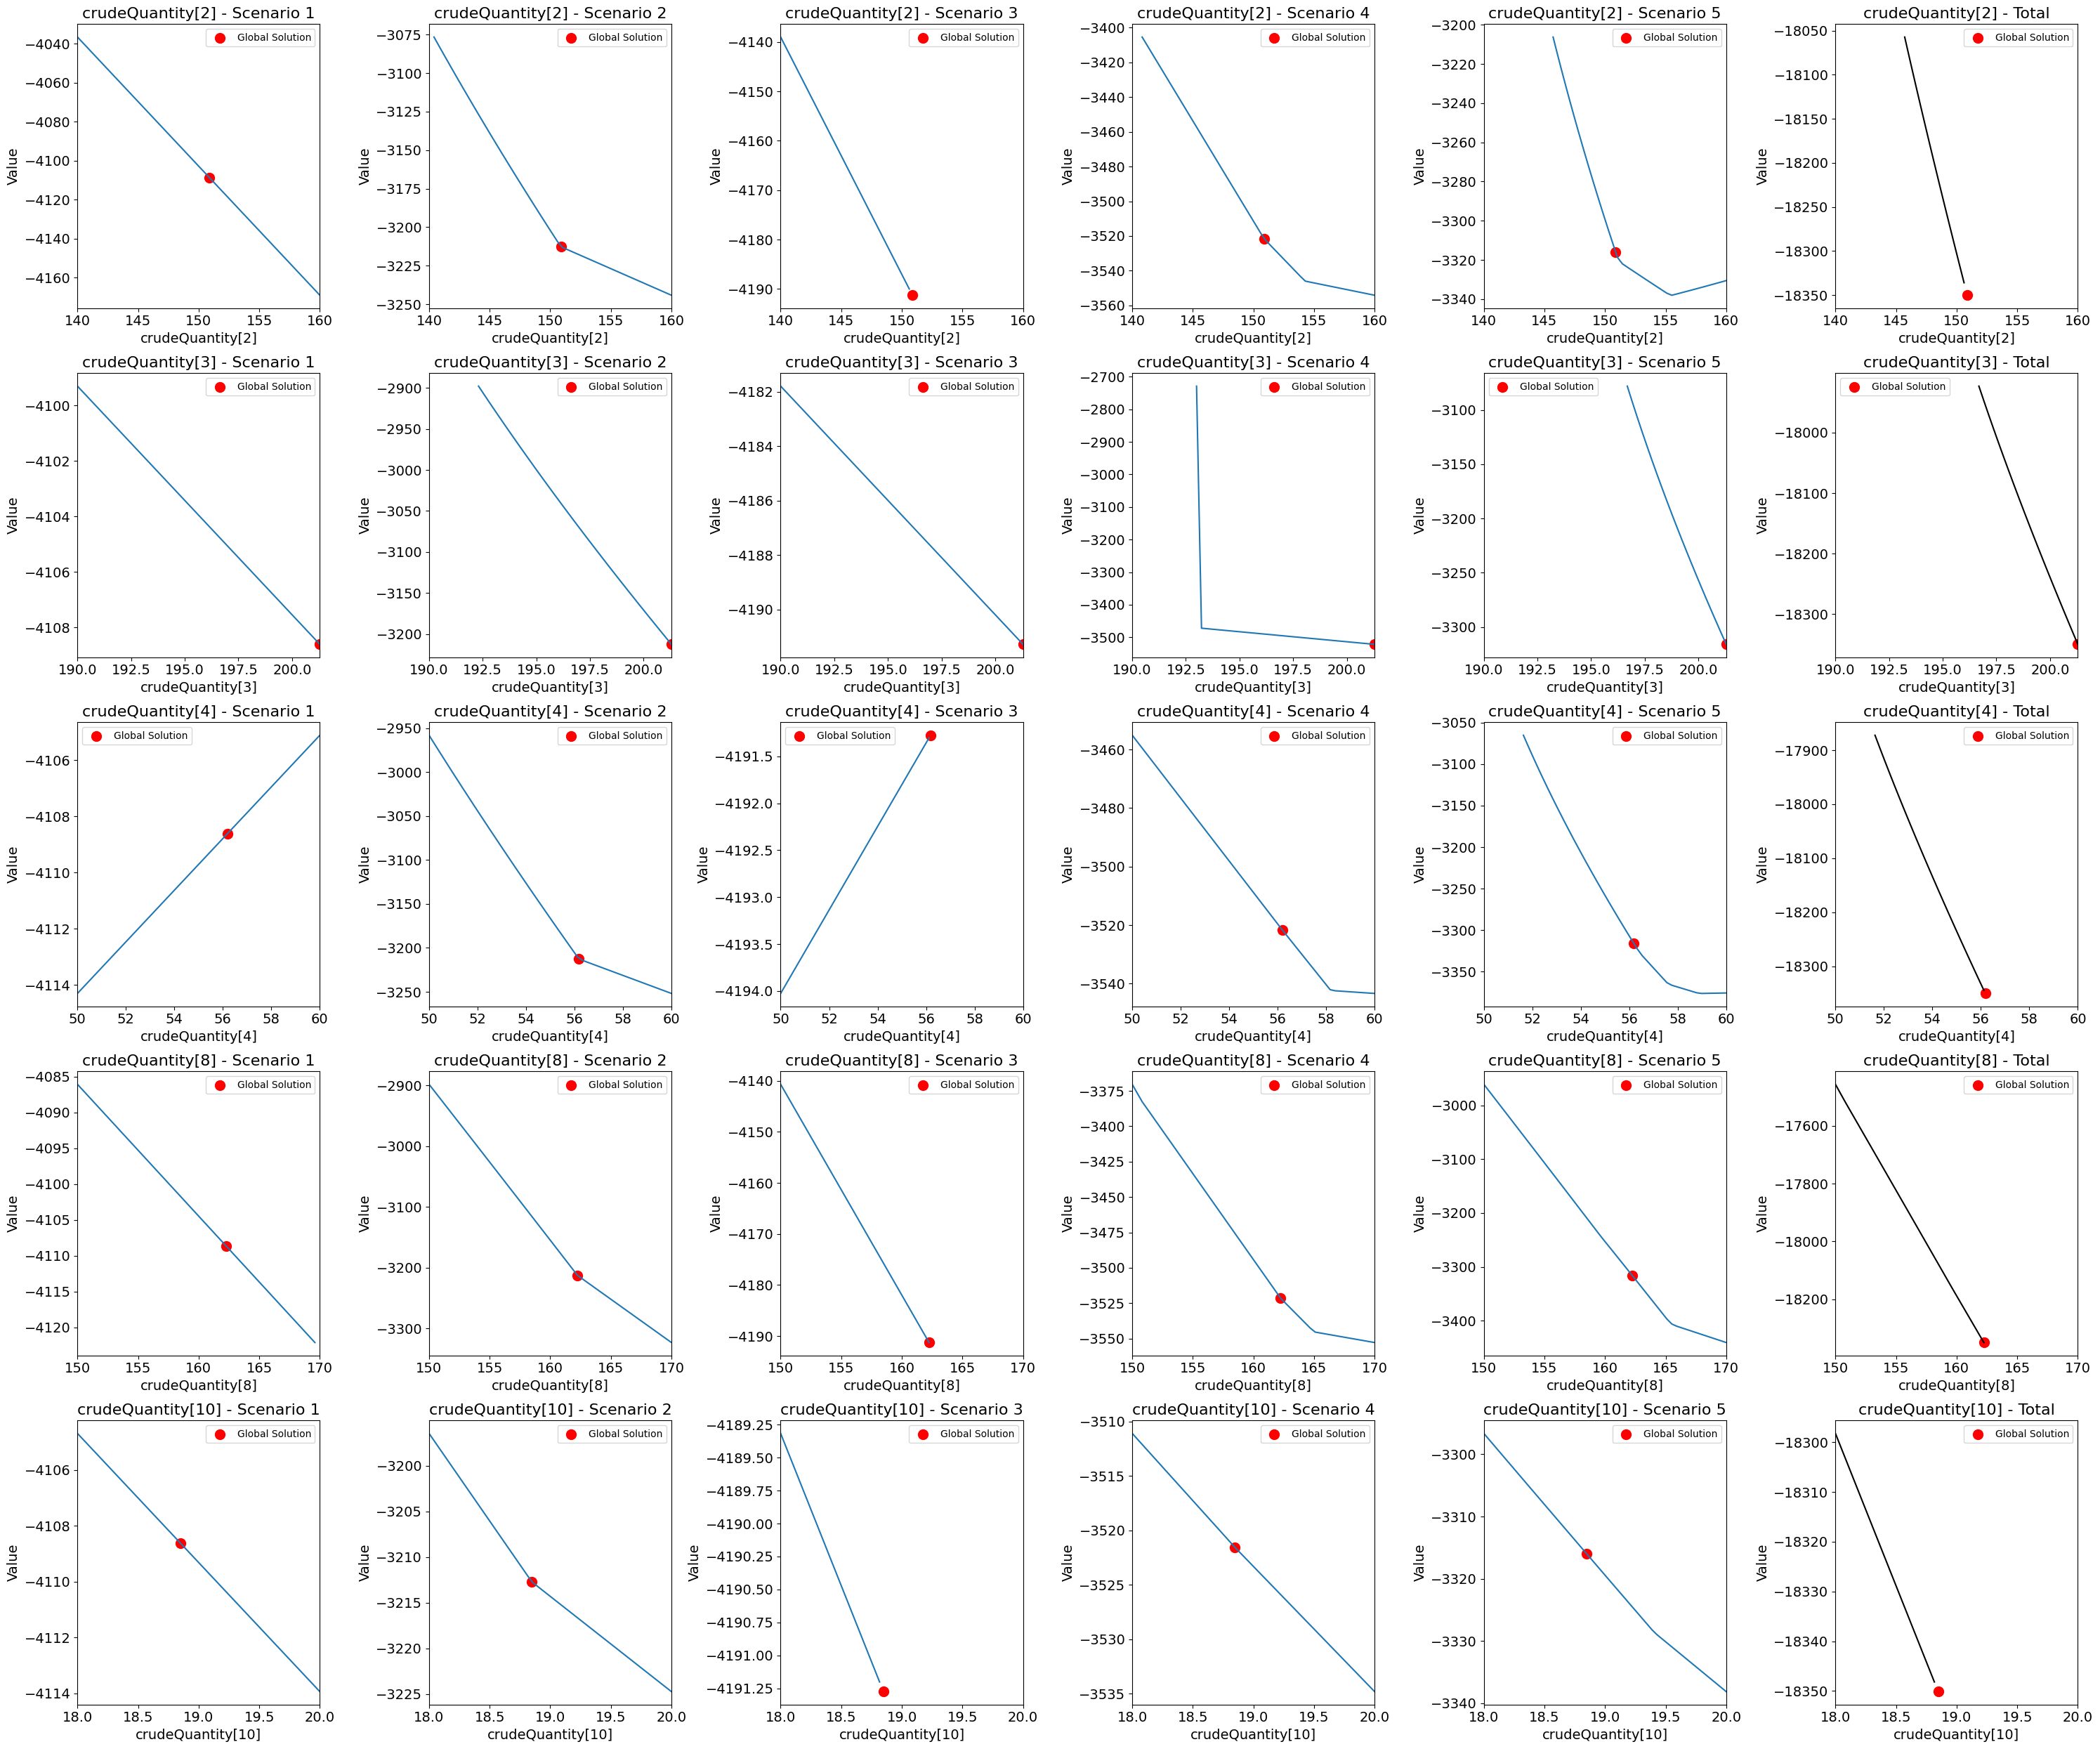

({'crudeQuantity[2]': {1: array([-4036.48789746, -4039.19467268, -4041.90145106, -4044.6082326 ,
          -4047.31501731, -4050.02180518, -4052.72859619, -4055.43539045,
          -4058.14218767, -4060.84898811, -4063.55579219, -4066.26259852,
          -4068.96940826, -4071.67622123, -4074.38303731, -4077.08985651,
          -4079.79667883, -4082.50350435, -4085.21033287, -4087.91716439,
          -4090.62399911, -4093.33083691, -4096.03767781, -4098.74452178,
          -4101.45136884, -4104.15821897, -4106.86507217, -4109.57192844,
          -4112.27878791, -4114.98565067, -4117.6925156 , -4120.39938409,
          -4123.10625563, -4125.81313074, -4128.52000784, -4131.22688849,
          -4133.93377229, -4136.64065944, -4139.34754917, -4142.05444138,
          -4144.76133715, -4147.46823605, -4150.17513825, -4152.88204305,
          -4155.58895031, -4158.2958611 , -4161.00277543, -4163.70969175,
          -4166.41661185, -4169.12353569]),
   2: array([           nan, -3076.60643113, 

In [1]:
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from NSPLIB.src.instances.crude_selection.crude_selection import const_model
from graphing.value_function.plotting import plotting
## global obj and solution
crude_obj = -18350.146929611754
crude_sol = {f'crudeQuantity[{i}]': 0. for i in range(1, 10 + 1)}
crude_sol['crudeQuantity[2]'] = 150.87595641747944
crude_sol['crudeQuantity[3]'] = 201.29570746971186
crude_sol['crudeQuantity[4]'] = 56.18456149457359
crude_sol['crudeQuantity[8]'] = 162.2466500589715
crude_sol['crudeQuantity[10]'] = 18.848116800048512
### original y_bound
# crude_y_bound = {
#     'crudeQuantity[1]': [0, 201.29570747217807],
#     'crudeQuantity[2]': [0, 212.48012718600953],
#     'crudeQuantity[3]': [0, 201.29570747217807],
#     'crudeQuantity[4]': [0, 199.57869634340224],
#     'crudeQuantity[5]': [0, 210.54848966613673],
#     'crudeQuantity[6]': [0, 222.1383147853736],
#     'crudeQuantity[7]': [0, 196.7885532591415],
#     'crudeQuantity[8]': [0, 208.54531001589828],
#     'crudeQuantity[9]': [0, 204.3720190779014],
#     'crudeQuantity[10]': [0, 210.2623211446741]
# }
### smaller y_bound to plot area near the solution
crude_y_bound = {
    'crudeQuantity[1]': [0, 201.29570747217807],
    'crudeQuantity[2]': [140, 160],
    'crudeQuantity[3]': [190, 201.29570747217807],
    'crudeQuantity[4]': [50, 60],
    'crudeQuantity[5]': [0, 210.54848966613673],
    'crudeQuantity[6]': [0, 222.1383147853736],
    'crudeQuantity[7]': [0, 196.7885532591415],
    'crudeQuantity[8]': [150,170],
    'crudeQuantity[9]': [0, 204.3720190779014],
    'crudeQuantity[10]': [18, 20]
}

## build model and fix binary variables in the first stage
sto_m = const_model()
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()
binary_ys = [f'pickCrude[{i}]' for i in range(1, 10 + 1)]
binary_y_val = {y: 0 for y in binary_ys}
binary_y_val['pickCrude[2]'] = 1
binary_y_val['pickCrude[3]'] = 1
binary_y_val['pickCrude[4]'] = 1
binary_y_val['pickCrude[8]'] = 1
binary_y_val['pickCrude[10]'] = 1
m.fix_binary_y(binary_y_val)
updated_y_bound=m.y_bound
updated_y_bound['crudeQuantity[1]']=(0,0)
updated_y_bound['crudeQuantity[5]']=(0,0)
updated_y_bound['crudeQuantity[6]']=(0,0)
updated_y_bound['crudeQuantity[7]']=(0,0)
updated_y_bound['crudeQuantity[9]']=(0,0)
m.update_y_bound(updated_y_bound)

# initialize dictionary to store the data for each dimension
y_dimension = {'crudeQuantity[2]':{}, 'crudeQuantity[3]':{}, 'crudeQuantity[4]':{},'crudeQuantity[8]':{}, 'crudeQuantity[10]':{}}
plotting(m, 50, y_dimension, crude_sol, crude_y_bound,crude_obj)